In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac
import utilities.chart_kwargs as ck

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md

# data sources
data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_gis.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",
    "dims_data":"dims_data.csv"
}

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-01-01'
end_date =today

# name of the output folder:
name_of_project = 'site_report_biel'

# set the maps
city_map = PILImage.open("resources/maps/burgdorf_locations_scaled.jpeg")
bassin_map = PILImage.open("resources/maps/aare_scaled.jpeg")

# these pick your aggregation set

# the city, lake and river bassin we are aggregating to
# the keys are column names in the survey data


# levels = {"city":"Saint-Gingolph","water_name_slug":'lac-leman', "river_bassin":'rhone'}
# level_names = [levels['city'],"Lac Léman","Rhône bassin"]


# La Tour-de-Peilz
# levels = {"city":"Vevey","water_name_slug":'lac-leman', "river_bassin":'rhone'}
# level_names = [levels['city'],"Lac Léman","Rhône bassin"]

# levels = {"city":"La Tour-de-Peilz","water_name_slug":'lac-leman', "river_bassin":'rhone'}
# level_names = [levels['city'],"Lac Léman","Rhône bassin"]

# levels = {"city":"Burgdorf","water_name_slug":'emme', "river_bassin":'aare'}


# levels = {"city":"Bern","water_name_slug":'aare', "river_bassin":'aare'}
# level_names = [levels['city'], "Aare","Aare bassin"]

levels = {"city":"Biel/Bienne","water_name_slug":'bielersee', "river_bassin":'aare'}
level_names = [levels['city'], "Bielersee","Aare bassin"]


# variables for the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# add the folder to the directory tree:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# convenience method
def m_ap_code_to_description(data, key, func):
    new_data = data.copy()
    new_data['item'] = new_data.index.map(lambda x: func(x,key ))
    new_data.set_index('item', inplace=True)
    return new_data

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [2]:
md(F"## <span style='color:#008891'>Municipal survey results: {levels['city']}</span>")

## <span style='color:#008891'>Municipal survey results: Biel/Bienne</span>

<a id='top'></a>
#### <span style="color:#008891">Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes (IQASL)</span>

IQASL est un projet soutenu par l'Office fédéral de l'environnement qui vise à quantifier les déchets sur les rives des lacs et rivières suisses dans les bassins versants du Rhône, de l'Aar, du Tessin et de la Linth/Limmat. Pour ce faire, de multiples enquêtes sur les déchets sont menées à petite échelle et de manière discrète sur l'ensemble du bassin versant. La majorité des échantillons sont prélevés dans les lacs.

#### <span style="color:#008891">Qu'est-ce qu'un recensement des déchets?</span>

Un recensement des déchets sauvages consiste à identifier et à compter tous les objets trouvés dans une zone délimitée et bordée d'un côté par de l'eau. Chaque objet est classé dans l'une des 260 catégories¹. Le lieu, la date, les dimensions de l'enquête et le nombre total d'objets dans chaque catégorie sont notés.

Les résultats du recensement sont présentés sous la forme d'un rapport entre le nombre d'objets trouvés et le nombre de mètres de rivages étudiés. Cela nous permet de comparer des enquêtes de tailles différentes.

#### <span style="color:#008891">Objectif du recensement</span>

Les résultats de l'enquête permettent à TOUS les acteurs concernés d'identifier les objets qui constituent la masse de déchets présents dans le milieu naturel sur les rives des lacs et rivières suisses. Les enquêtes répondent aux questions suivantes :

1. Quels sont les objets trouvés ?
2. Quelle quantité a-t-on trouvé ? (poids total et nombre d'objets)
3. A quelle fréquence ces articles sont-ils trouvés ?
4. Où en trouvez-vous le plus ?

Ces questions sont les plus fréquemment posées et doivent être prises en compte lors de la détermination de toute stratégie d'atténuation ou de réduction.

Le projet est basé sur les hypothèses suivantes:

1. Plus il y a de déchets sur le sol, plus une personne est susceptible d'en trouver.
2. Les résultats du recensement représentent la quantité minimale de déchets sur ce site².
3. Pour chaque recensement : le fait de trouver un objet n'affecte pas la probabilité d'en trouver un autre³.

#### <span style="color:#008891">Objectif de ce rapport</span>

Résumez les résultats des recensements pour la municipalité et définissez l'ampleur de ces résultats par rapport aux autres sites du bassin versant et aux résultats nationaux agrégés.

#### <span style="color:#008891">Contenu de ce rapport</span>

1. [Description du bassin fluvial](#scope)
2. [Dimensions, emplacements, totaux agrégés](#communesummary)
3. [Déchets enlevés : dix premiers résultats combinés](#combinedtopten)
4. [Déchets enlevés : type de matériau et utilisation](#matanduse)
5. [Déchets enlevés le plus souvent](#fréquence)
6. [Annexe](#annexe) : Détails de l'emplacement de l'enquête, liste détaillée des déchets enlevés.

#### <span style="color:#008891">More information </span>

Pour plus d'informations sur le projet, consultez le site [project home](https://www.plagespropres.ch/).

Si vous souhaitez que votre municipalité fasse l'objet d'une enquête régulière, contactez-nous:

1. Swiss federal office for the environment - Municipal waste section
2. hammerdirt

¹ [The EU guide on monitoring marine litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf)<br> ² TIl y a très probablement plus de déchets sur le site de l'enquête, mais certainement pas moins que ce qui a été enregistré.<br>³ Observations indépendantes: [stats stackexchange](https://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean)

In [3]:
# define the methods to use for the .JSON and .csv files:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups, dfDims = ac.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

# format the date to timestamp and slice the data by start/end date
dfSurveys = ac.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

# add the grouping column defined by river_bassins
data = ac.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# Create new codes to aggregate the EPS pieces and the Plastic pieces
a_foam_code = dfCodes.loc['G82'].copy()
a_foam_code['description'] = 'expanded polystyrene'
dfCodes.loc['Gfoam'] = a_foam_code

a_plastic_code = dfCodes.loc['G79'].copy()
a_plastic_code['description'] = 'Fragmented plastics'
dfCodes.loc['Gfrags'] = a_plastic_code

# these codes have long descriptions, they are abbreviated for display
dfCodes.loc['G74', 'description'] = "Foams not expanded polystyrene"
dfCodes.loc['G940', 'description'] = "Foamed EVA for crafts and sports"
dfCodes.loc['G96', 'description'] = 'Sanitary-pads/panty liners/tampons'

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

# put the data into a class
# kwargs for the abundance class
a_class_kwargs = dict(
    code_group_data=code_groups,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects'],       
    code_group_loc=output,    
)

# the data labled by river bassin, water feature, city and beach name with independent variables attached
a = ac.PreprocessData(data,  dfBeaches, these_cols=['loc_date', 'location', 'water_name_slug','date'], **a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()
foam_sums = a_data[a_data.code.isin(['G81', 'G82', 'G83'])].groupby('loc_date', as_index=False).agg({'quantity':'sum', 'pcs_m':'sum'})
plast_sums = a_data[a_data.groupname == 'plastic pieces'].groupby('loc_date', as_index=False).agg({'quantity':'sum', 'pcs_m':'sum'})                                  

# applying the temporary codes for this report
foamsurveys = foam_sums.loc_date.unique()
foamrows = []
for adate in foamsurveys:
    gx = a_data[(a_data.loc_date == adate)&(a_data.code=='G82')].copy()
#     gx = gx.iloc[0]
    gx['code'] = 'Gfoam'
    gx['quantity'] = foam_sums[foam_sums.loc_date == adate].quantity
    gx['pcs_m'] = foam_sums[foam_sums.loc_date == adate].pcs_m
    foamrows.append(gx)

the_foam_rows = these = pd.concat(foamrows)

plastsurveys = plast_sums.loc_date.unique()
plastrows = []
for adate in plastsurveys:
    gx = a_data[(a_data.loc_date == adate)&(a_data.code=='G79')].copy()
    gx['code'] = 'Gfrags'
    
    gx['quantity'] =plast_sums[plast_sums.loc_date == adate].quantity.values[0]
    gx['pcs_m'] = plast_sums[plast_sums.loc_date == adate].pcs_m.values[0]
    plastrows.append(gx)

the_plast_rows = these = pd.concat(plastrows)


som_data = a_data[~a_data.code.isin(['G81', 'G82', 'G83'])].copy()
som_data = som_data[som_data.groupname != 'plastic pieces'].copy()
som_data = som_data.append(the_plast_rows, ignore_index=True)

a_data = som_data.append(the_foam_rows, ignore_index=True)

# identify all records with a quantity > 0
a_data['fail'] = a_data.quantity > 0

# map material to a_data
a_data['material'] = a_data.code.map(lambda x: code_material_map[x])
material_totals = a_data.groupby('material').quantity.sum()

# get group totals:
group_totals = a_data[a_data.quantity > 0].groupby(['loc_date','groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
group_totals_all = group_totals.groupby(['groupname']).agg({'pcs_m':'median', 'quantity':'sum'})

# get top ten
a_t_ten = a.code_totals.sort_values(ascending=False)

# number of samples
a_n_samps = len(a.daily_totals_all)

# thats it! all the survey records with the independent variables attached and columns to group by
# date, location, (location, date), river bassin, water body, city, material, usage group, or object

# define the data set for this example:
trb = a_data.loc[a_data.river_bassin == levels['river_bassin']].copy()

# get the fail rates for the river bassin
fail_rates_trb = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code')

# survey_totals river bassin
dts=trb.groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()

# code totals for the river bassin
rb_code_t= trb.groupby('code', as_index=False).quantity.sum()

# percent of total
rb_code_t["% of total"] = rb_code_t.quantity/rb_code_t.quantity.sum()
rb_code_t.set_index('code', inplace=True)

# river bassin top ten
rb_t_ten = rb_code_t['quantity'].sort_values(ascending=False)

# get groupname totals
trb_group_totals = trb[trb.quantity > 0].groupby(['loc_date','groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
trb_group_totals = trb_group_totals.groupby(['groupname']).agg({'pcs_m':'median', 'quantity':'sum'})

rb_n_samps = len(trb.loc_date.unique())
rb_num_obj = trb.quantity.sum()
rb_num_locs = len(trb.location.unique())
rb_locs = trb.location.unique()

# rb dimensional data
rb_dims = dfDims[dfDims.location.isin(trb.location.unique())]
rb_dims_sum = rb_dims.agg({'length':'sum', 'area':'sum', 'time_minutes':'sum', 'total_w':'sum','mac_plast_w':'sum'})
rb_dims_sum['pcs/m - median'] = dts.pcs_m.median()
rb_dims_sum['# déchets'] = trb.quantity.sum()
rb_dims_sum['# lieux'] = trb.location.nunique()
rb_dims_sum['# sondages'] = len(trb.loc_date.unique())

rb_dims_sum.rename({'length':'Mètres de berges', 'area':'m² totale', 'time_minutes':'heures', 'total_w':'# kilos total', 'mac_plast_w':'# kilos plastic'}, inplace=True)
rb_dims_sum['heures'] = rb_dims_sum['heures']/60
rb_dims_sum[ '# kilos plastic'] = rb_dims_sum[ '# kilos plastic']/1000

# the water body
f_data = trb[trb.water_name_slug == levels['water_name_slug']].copy()
f_n_samps = len(f_data.loc_date.unique())

# code totals for the river bassin
f_code_t= f_data.groupby('code', as_index=False).quantity.sum()

# percent of total
f_code_t["% of total"] = f_code_t.quantity/f_code_t.quantity.sum()
f_code_t.set_index('code', inplace=True)

# river bassin top ten
f_t_ten = f_code_t['quantity'].sort_values(ascending=False)

# the city that we are looking at:
biel = trb[trb.city == levels['city']].copy()
c_beaches = biel.location.unique()

# all the survey locations in the city
city_beaches = dfBeaches.loc[dfBeaches.index.isin(c_beaches)][['location','latitude','longitude', 'water_name', 'bfsnum']]


city_beaches.rename(columns={'water_name':'lake/river'}, inplace=True)
city_beaches = city_beaches.set_index('location', drop=True)

# the top ten codes by quantity
city_code_t  = biel.groupby('code', as_index=False).quantity.sum()
city_code_t["% of total"] = city_code_t.quantity/city_code_t.quantity.sum()
city_code_t.set_index('code', inplace=True)
city_t_ten = city_code_t['quantity'].sort_values(ascending=False)

# survey totals city
the_city = trb[trb.city == levels['city']].groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()
survey_totals_median = the_city.pcs_m.median()
c_n_samps = len(biel.loc_date.unique())

# more_than_one_sample = len(the_city.loc_date.unique()) > 1

# end of report print out of total inventory
biel['item'] = biel.code.map(lambda x: code_description_map[x])
complete_inventory = biel.loc[biel.quantity > 0].groupby(['item','code','material','groupname'], as_index=True).agg({'quantity':'sum', 'pcs_m':'median'})

# dimensional data
biel_dims = dfDims[dfDims.location.isin(biel.location.unique())]
biel_dims_sum = biel_dims.agg({'loc_date':'nunique', 'length':'sum', 'area':'sum', 'time_minutes':'sum', 'total_w':'sum','mac_plast_w':'sum'})
biel_dims_sum['pcs_m'] = survey_totals_median
biel_dims_sum['quantity'] = biel.quantity.sum()
biel_dims_sum['locations'] = biel.location.nunique()

# locations at biel
biel_loc = biel.location.unique()

# fail rate
biel_fail = biel.loc[biel.quantity > 0]
biel_nfail = len(biel_fail.code.unique())

In [4]:
md(F"""### <a id='scope'></a><span style='color:#008891'>Le bassin versant: {level_names[2]}</span>
Lieux de recensement 2020/2021
""")

### <a id='scope'></a><span style='color:#008891'>Le bassin versant: Aare bassin</span>
Lieux de recensement 2020/2021



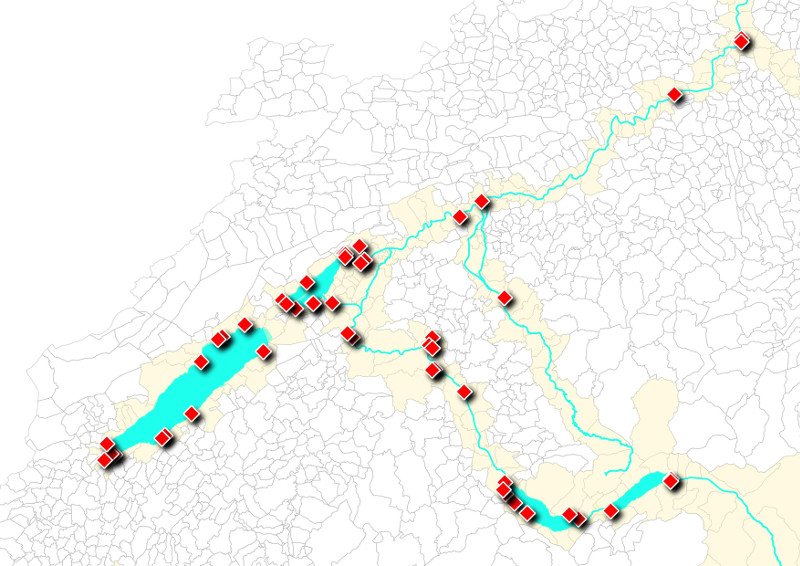

In [5]:
output = io.BytesIO()
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

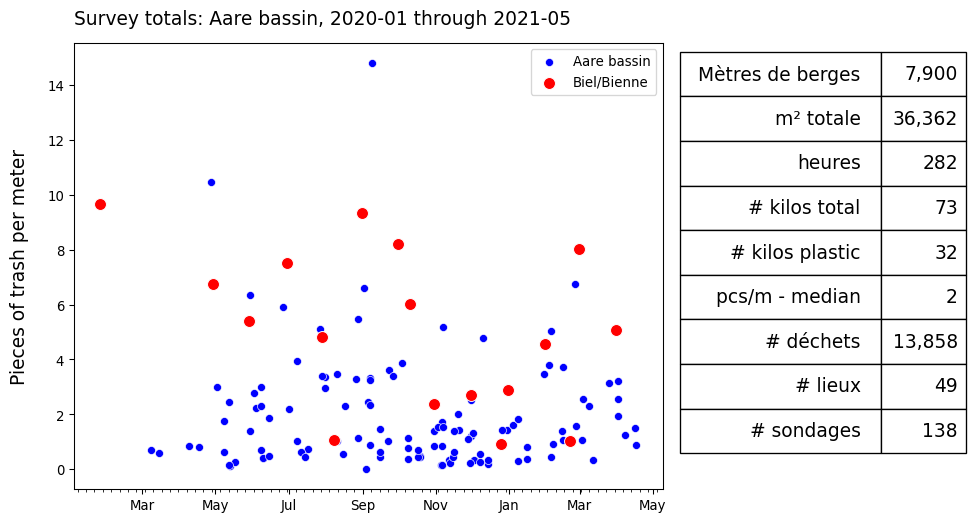

In [6]:
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

table_vals = [math.ceil(x) for x in rb_dims_sum.values]
table_str_vals = ['{:,}'.format(x) for x in table_vals]
table_data = list(zip(rb_dims_sum.index,table_str_vals ))

fig = plt.figure(figsize=(12,6), dpi=96)
gs = GridSpec(1, 12, figure=fig, wspace=.3, hspace=.3, top=.9)

axone = fig.add_subplot(gs[:, :8])
# axone = axs[0]
axtwo = fig.add_subplot(gs[:, 8:])
# axone=axs[0]
# axtwo=axs[1]

sns.scatterplot(data=dts, x='date', y='pcs_m', color='b', label=F"{level_names[2]}", ax=axone)
sns.scatterplot(data=the_city, x='date', y='pcs_m', color='r', s=80, label=levels['city'], ax=axone)

axone.set_xlabel("")
axone.set_ylabel("Pieces of trash per meter", **ck.xlab_k14)
axone.set_title(F"Survey totals: {level_names[2]}, {start_date[:7]} through {end_date[:7]}",  **ck.title_k14)
axone.xaxis.set_minor_locator(days)
axone.xaxis.set_major_formatter(months_fmt)

a_table = axtwo.table(table_data, loc='upper center', fontsize=14, colWidths=[.70,.30])
a_table.auto_set_font_size(False)
a_table.set_fontsize(14)

table_rows = a_table.get_celld()
# for cell in table_rows:
#     cell.facecolor = 'blue'
cellDict = a_table.get_celld()
for i in range(0,2):
    cellDict[(0,i)].set_height(.1)
    for j in range(1,len(table_data)):
        cellDict[(j,i)].set_height(.1)

axtwo.grid(False)
axtwo.axis('off')

plt.show()
plt.close()

In [7]:
section_header = F"[top](#top)\n### <a id='communesummary'></a><span style='color:#008891'>Synthèse des résultats: {levels['city']}</span>"
md(section_header)

[top](#top)
### <a id='communesummary'></a><span style='color:#008891'>Synthèse des résultats: Biel/Bienne</span>

In [8]:
summary = F"""1. Nombre de prélèvements: {int(biel_dims_sum['loc_date'])}\n
2. Nombre de lieux: {int(biel_dims_sum['locations'])}\n 
3. Mètres de berges: {int(biel_dims_sum['length'])}
4. Surface totale: {'{:,}'.format(int(biel_dims_sum['area']))}m²
5. Durée totale en heures: {int(biel_dims_sum['time_minutes']/60)}
6. Déchets par mètre de berges: {round(biel_dims_sum['pcs_m'],2)}
7. Nombre de déchets collectés: {'{:,}'.format(int(biel_dims_sum['quantity']))}
8. Kilograms de déchets collectés : {round(biel_dims_sum['total_w'], 2)}
9. Kilograms de plastic collectés: {round((biel_dims_sum['mac_plast_w']/1000), 2)}
"""
md(summary)

1. Nombre de prélèvements: 17

2. Nombre de lieux: 3
 
3. Mètres de berges: 697
4. Surface totale: 5,092m²
5. Durée totale en heures: 47
6. Déchets par mètre de berges: 5.06
7. Nombre de déchets collectés: 3,309
8. Kilograms de déchets collectés : 8.2
9. Kilograms de plastic collectés: 4.0


In [9]:
section_header = F"#### <span style='color:#008891'>Lieux de recensement {levels['city']}</span>"
md(section_header)

#### <span style='color:#008891'>Lieux de recensement Biel/Bienne</span>


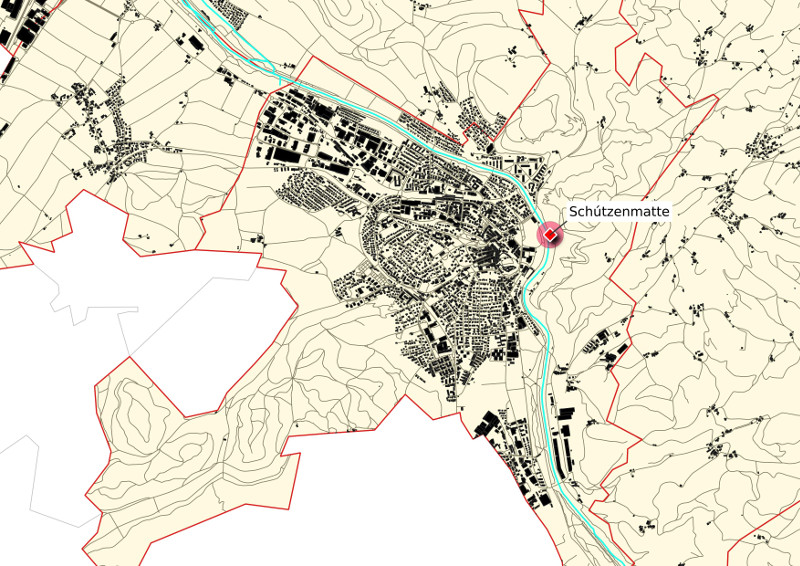

In [10]:
output = io.BytesIO()
city_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

[top](#top)
<a id='combinedtopten'></a>
### <span style='color:#008891'>Les 10 déchets trouvés en plus grande quantité : déchets par mètre.</span>

In [11]:
add_feature_top_ten = f_n_samps > 1

astring = "Les résultats du recensement varient d'une région à l'autre. Si votre commune présente des résultats plus élevés pour un objet ou un groupe particulier, il se peut que vous soyez proche de la source ou d'une zone d'accumulation."

if add_feature_top_ten:
    an_alert = F"Le top 10 des déchets de {levels['city']} et {level_names[1]}.\n {astring}"
else:
    an_alert = F"Le top 10 des déchets de {levels['city']} et {level_names[2]}.\n {astring}"
md(an_alert)

Le top 10 des déchets de Biel/Bienne et Bielersee.
 Les résultats du recensement varient d'une région à l'autre. Si votre commune présente des résultats plus élevés pour un objet ou un groupe particulier, il se peut que vous soyez proche de la source ou d'une zone d'accumulation.

In [12]:
# get the top ten at each aggregation level
the_top_ten_combined = set([*city_t_ten.index[:10], *f_t_ten.index[:10], *rb_t_ten.index[:10], *a_t_ten.index[:10]])

#kwargs for aggregator
these_kwargs = dict(
    group='code',
    dailycols={'pcs_m':'sum', 'quantity':'sum'}, 
    agg_cols={"pcs_m":"mean"},
    national=True,
    col_name="All river bassins",
    level_names=level_names,
    daily=True)
    
# the top ten from the city 
t_ten_city = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(city_t_ten.index[:10] ))], levels, **these_kwargs)

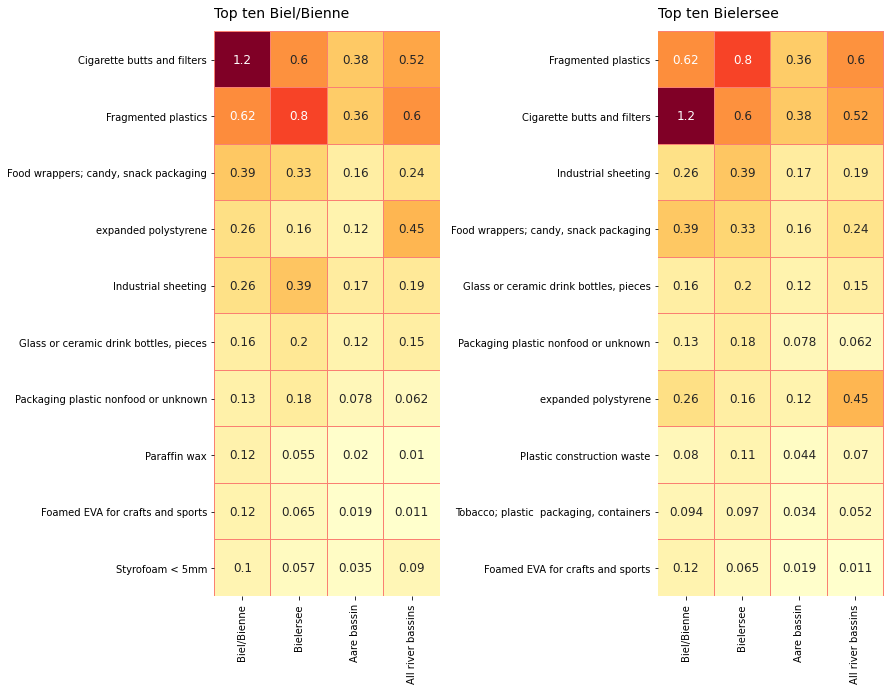

In [13]:
# reindex to description
t_ten_city['item'] = t_ten_city.index.map(lambda x: code_description_map[x])
code_t_ten = t_ten_city.set_index('item', drop=True)
code_t_ten.sort_values(by=levels['city'], ascending=False, inplace=True)
# code_t_ten.rename(columns=level_names, inplace=True)

# compare to either the closest water feature or the river bassin
if add_feature_top_ten:
    second_chart = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(f_t_ten.index[:10]))], levels, **these_kwargs)
    second_chart['item'] = second_chart.index.map(lambda x: code_description_map[x])
    second_chart = second_chart.set_index('item', drop=True)
   
    second_chart.sort_values(by=level_names[1], ascending=False, inplace=True)
#     second_chart.rename(columns=level_names, inplace=True)
    second_chart_title = level_names[1]
else:
    second_chart = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(rb_t_ten.index[:10]))], levels, **these_kwargs)
    second_chart['item'] = second_chart.index.map(lambda x: code_description_map[x])
    second_chart = second_chart.set_index('item', drop=True)
    
    second_chart.sort_values(by=level_names[2], ascending=False, inplace=True)
  
    second_chart_title = F"{level_names[2]}"


# chart that
fig = plt.figure(figsize=(12,14))
gs = GridSpec(12, 3, figure=fig, wspace=.5, hspace=.5, top=.9, width_ratios=[.45,.1,.45])

axone = fig.add_subplot(gs[:, 0])
# axone = axs[0]
axtwo = fig.add_subplot(gs[:, 2])

sns.heatmap(code_t_ten, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.2',  square=True, cbar=False, linewidth=.05, linecolor='salmon')
axone.set_title(F"Top ten {levels['city']}", **ck.title_k14)
# axone.set_xlabel("Combined top ten pcs/m", **ck.label_r14)
# axone.tick_params(**ck.xlabels_top, **ck.no_xticks)
axone.set_ylabel("")

sns.heatmap(second_chart, ax=axtwo, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.2',  square=True, cbar=False, linewidth=.05, linecolor='salmon')
axtwo.set_title(F"Top ten {second_chart_title}", **ck.title_k14)
# axtwo.set_xlabel("Combined top ten pcs/m", **ck.label_r14)
# axtwo.tick_params(**ck.xlabels_top, **ck.no_xticks)
axtwo.set_ylabel("")

plt.setp(axone.get_xticklabels(), rotation=90)
plt.setp(axtwo.get_xticklabels(), rotation=90)

plt.show()
plt.close()

[top](#top)
<a id='matanduse'></a><a id='scope'></a>
### <span style='color:#008891'>Type de matériau et utilité : pourcentage du total des objets collectés</span>

**Type de matériau** Le type de matériau est déterminé sur la base de la classification du guide sur le suivi des déchets marins. 

**Utilité** Le type d'utilité est basé sur l'utilisation de l'objet avant qu'il ne soit jeté. Si les objets peuvent être
identifiés, ils sont regroupés dans l'une des 260 catégories. Ces catégories sont regroupées en fonction de l'utilisation.

Par exemple, un morceau de plastique sera placé dans la catégorie "plastiques fragmentés", en fonction de sa taille. Cependant, un morceau de plastique qui était autrefois un seau
et nous le savons parce que nous sommes familiers avec la marque ou le produit, est placé dans un code pour les seaux.

Dans les tableaux ci-dessous, chaque colonne présente les résultats pour la région indiquée. Plus la couleur est foncée, plus ce groupe d'objets pose problème par rapport à tous les autres objets trouvés dans cette région.

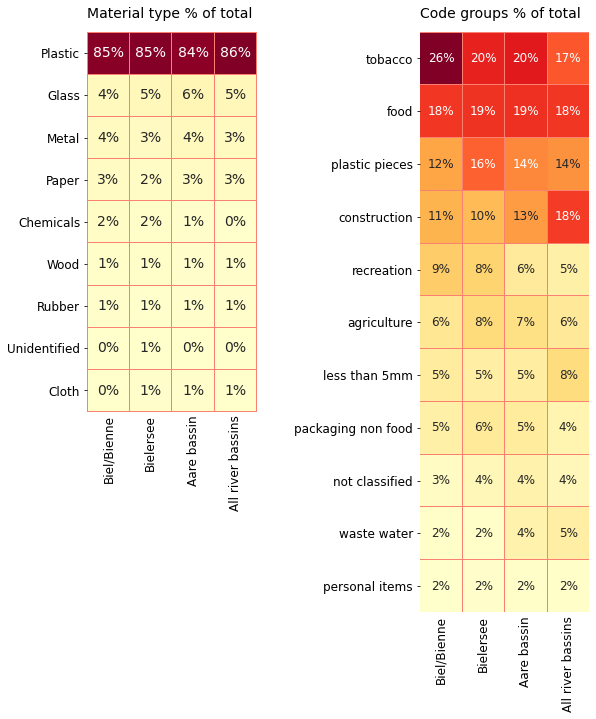

In [14]:
column_denominators = [
    biel.quantity.sum(),
    trb[trb.water_name_slug == levels['water_name_slug']].quantity.sum(),
    trb.quantity.sum(),
    a_data.quantity.sum()
]

code_group_kwargs = dict(
    group='groupname',
    dailycols={'pcs_m':'sum', 'quantity':'sum'},
    agg_cols={'quantity':'sum'},
    national=True,
    col_name="All river bassins",
    daily=False,
    level_names=level_names
)

code_groups_pcs_m = ac.agg_pcs_m_by_city_feature_basin_all(a_data, levels,**code_group_kwargs)
code_groups_pcs_m.sort_values(by=levels['city'], ascending=False, inplace=True)
  
cgroup_p_t = code_groups_pcs_m.divide(column_denominators).round(3)

material_group_kwargs = dict(
    group='material',
    dailycols={'pcs_m':'sum', 'quantity':'sum'},
    agg_cols={'quantity':'sum'},
    national=True,
    col_name="All river bassins",
    daily=False,
    level_names=level_names
)

material_groups_pcs_m = ac.agg_pcs_m_by_city_feature_basin_all(a_data, levels, **material_group_kwargs)
material_groups_pcs_m.sort_values(by=levels['city'], ascending=False, inplace=True)

mat_g_h = material_groups_pcs_m.divide(column_denominators).round(3)


fig = plt.figure(figsize=(9,14))

gs = GridSpec(12, 3, figure=fig, wspace=.5, hspace=.5, top=.9, width_ratios=[.45,.1,.45])


axone = fig.add_subplot(gs[0:6, 0])
sns.heatmap(mat_g_h, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":14}, fmt='.0%', cbar=False, linewidth=.01, linecolor='salmon')
axone.set_title("Material type % of total", **ck.title_k14)
axone.tick_params(**ck.no_xticks)
axone.set_ylabel("")

axtwo = fig.add_subplot(gs[0:9, 2])
sns.heatmap(cgroup_p_t, ax=axtwo, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.0%',   cbar=False, linewidth=.01, linecolor='salmon')

axtwo.set_title("Code groups % of total", **ck.title_k14)
axtwo.tick_params(**ck.no_xticks)
axtwo.set_ylabel("")

plt.setp(axtwo.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(axtwo.get_yticklabels(), rotation=0, fontsize=12)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=12)
plt.show()

### <span style='color:#008891'>Quelle est la fréquence de détection de ces objets ?</span>

In [15]:
add_feature_top_ten = f_n_samps > 1
city_fail_rate = c_n_samps > 1



astring = "Certains objets sont trouvés souvent et en grande quantité, d'autres sont trouvés souvent et en petite quantité et d'autres encore sont trouvés moins souvent mais en grande quantité. Connaître la différence peut aider à trouver les sources."

if add_feature_top_ten:
    first_level = levels['city']
    second_level = levels['water_name_slug']
    fail_codes=list(set([*city_t_ten.index[:10],*f_t_ten.index[:10]]))
    
else:
    first_level = levels['city']
    second_level = levels['river_bassin']
    fail_codes=list(set([*city_t_ten.index[:10],*rb_t_ten.index[:10]]))
    
an_alert = F"Fréquence de détection de {first_level} et {level_names[2]}.\n {astring}"
md(an_alert)

Fréquence de détection de Biel/Bienne et Aare bassin.
 Certains objets sont trouvés souvent et en grande quantité, d'autres sont trouvés souvent et en petite quantité et d'autres encore sont trouvés moins souvent mais en grande quantité. Connaître la différence peut aider à trouver les sources.

In [16]:
# this is a convenience function for the abundance class
# the fail rate needs to be recalculated at each aggregation level
fail_rates_df = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code')

a_fail_rate = 60

d = fail_rates_df[(fail_rates_df.iloc[:, :] > (a_fail_rate/100)).any(axis=1)]

# top ten from both levels and > 50% fail raite
frst_level_fail = d.loc[d.index.isin(fail_codes)][first_level].sort_values(ascending=False)[:10].index


objs_both = frst_level_fail
objs_fail_not_t_ten = list(set(fail_codes)-set(frst_level_fail))
objs_not = [x for x in d.index if x not in fail_codes]

In [17]:
pcs_d_both = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_both))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
found_fail = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_both])]
found_fail = ' '.join(found_fail )
md(F"""**Objets trouvés dans PLUS DE {a_fail_rate}% des recensements et dans les dix premiers en quantité**<br>
Ensemble, ils avaient une moyenne de pièces par mètre par recensement de {round(pcs_d_both['mean'], 2)}, minimum de {round(pcs_d_both['min'], 2)}, maximum de {round(pcs_d_both['max'], 2)}<br>
{found_fail}\n
""")

**Objets trouvés dans PLUS DE 60% des recensements et dans les dix premiers en quantité**<br>
Ensemble, ils avaient une moyenne de pièces par mètre par recensement de 3.32, minimum de 0.37, maximum de 6.76<br>
<br/>1. Fragmented plastics <br/>2. Cigarette butts and filters <br/>3. Food wrappers; candy, snack packaging <br/>4. expanded polystyrene <br/>5. Industrial sheeting <br/>6. Tobacco; plastic  packaging, containers <br/>7. Plastic construction waste <br/>8. Glass or ceramic drink bottles, pieces <br/>9. Packaging plastic nonfood or unknown <br/>10. Styrofoam < 5mm



In [18]:
if len(objs_fail_not_t_ten) > 0:
    pcs_d_fail = a_data[(a_data.quantity > 0)&(a_data.code.isin(objs_fail_not_t_ten))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
    not_found_fail = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_fail_not_t_ten])]
    not_found_fail = ' '.join(not_found_fail)
    a_string = F"""**Objets trouvés dans MOINS DE {a_fail_rate}% des recensements et dans les dix premiers en quantité**<br>Ensemble, ils avaient une moyenne de pièces par mètre par recensement de {round(pcs_d_fail['mean'], 2)}, minimum de {round(pcs_d_fail['min'], 2)}, maximum de {round(pcs_d_fail['max'], 2)}
    <br>{not_found_fail}\n
    """   
else:
    a_string="\n"


md(a_string)

**Objets trouvés dans MOINS DE 60% des recensements et dans les dix premiers en quantité**<br>Ensemble, ils avaient une moyenne de pièces par mètre par recensement de 0.11, minimum de 0.01, maximum de 0.86
    <br><br/>1. Foamed EVA for crafts and sports <br/>2. Paraffin wax

    

In [19]:
if len(objs_not) > 0:
    pcs_d_pcs = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_not))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
    fail_not_found = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_not])]
    fail_not_found = ' '.join(fail_not_found )
    astring = F"""**Objets trouvés dans PLUS DE {a_fail_rate}% des recensements mais NON dans les dix premiers en quantité**<br>Ensemble, ils avaient une moyenne de pièces par mètre par recensement de {round(pcs_d_pcs['mean'], 2)}, minimum de {round(pcs_d_pcs['min'], 2)}, maximum de {round(pcs_d_pcs['max'], 2)}
    <br>{fail_not_found}\n    
    """
else:
    astring = ""

md(astring)

**Objets trouvés dans PLUS DE 60% des recensements mais NON dans les dix premiers en quantité**<br>Ensemble, ils avaient une moyenne de pièces par mètre par recensement de 0.66, minimum de 0.04, maximum de 1.38
    <br><br/>1. Food containers single use foamed or plastic <br/>2. Plastic fragments angular <5mm <br/>3. Industrial pellets (nurdles) <br/>4. Foil wrappers, aluminum foil <br/>5. Metal bottle caps, lids & pull tabs from cans <br/>6. Other medical items (swabs, bandaging, adhesive plaster) <br/>7. Lid/cap rings from plastic bottles/containers <br/>8. Lollypop sticks <br/>9. Straws and stirrers <br/>10. String < 1cm <br/>11. Foams not expanded polystyrene <br/>12. Fireworks; rocket caps, exploded parts & packaging <br/>13. Cotton bud/swab sticks
    
    

### <span style="color:#008891">Plus d'informations</span>

Contactez roger@hammerdirt.ch or 076 699 06 16 pour toute question concernant le contenu de ce rapport.

In [20]:
author = "roger@hammerdirt.ch"
md(F"""### <span style="color:#000099">Have a great day</span>
**Ce projet a été rendu possible par l'Office fédéral de l'environnement Suisse.**<br>
Ce document provient de https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*{author}* a appuyé sur le bouton "Run" le {today}.
""")

### <span style="color:#000099">Have a great day</span>
**Ce projet a été rendu possible par l'Office fédéral de l'environnement Suisse.**<br>
Ce document provient de https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*roger@hammerdirt.ch* a appuyé sur le bouton "Run" le 2021-05-07.


[top](#top)
<a id=annex></a>
### <span style="color:#008891">Annexe</span>

#### Lieux de recensement

In [21]:
city_beaches

,latitude,longitude,lake/river,bfsnum
location,,,,
Müllermatte,47.133339,7.227907,Bielersee,371
Schüsspark strand,47.146500,7.268620,Schüss,371
Strandboden-Biel,47.132510,7.233142,Bielersee,371


#### Inventaire de tous les articles retirés

In [22]:
pd.set_option('display.max_rows', None)
complete_inventory.sort_values(by='quantity', ascending=False)

,,,,quantity,pcs_m
item,code,material,groupname,,
Cigarette butts and filters,G27,Plastic,tobacco,781,1.150
Fragmented plastics,Gfrags,Plastic,plastic pieces,403,0.500
"Food wrappers; candy, snack packaging",G30,Plastic,food,253,0.415
Industrial sheeting,G67,Plastic,agriculture,166,0.255
expanded polystyrene,Gfoam,Plastic,construction,163,0.200
Packaging plastic nonfood or unknown,G941,Plastic,packaging non food,95,0.140
"Glass or ceramic drink bottles, pieces",G200,Glass,food,94,0.080
Foamed EVA for crafts and sports,G940,Plastic,recreation,84,0.090
Paraffin wax,G213,Chemicals,recreation,75,0.145
